In [39]:
# Test importing of video in opencv
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
%matplotlib widget

# Stored video file location
# fdir = '/home/chris/cattown/'
fdir = 'C:\\Chris\\cattown\\' # windows option :(
fname = '2024-03-22 first trial.mov'

cv.destroyAllWindows()

In [40]:
# Some helper functions to analyze the moving object contour

def get_centroid(contour):
    ''' Get centroid of an openCV 2d contour '''
    row = int( np.round( contour[:,0,0].mean() ) )
    col = int( np.round( contour[:,0,1].mean() ) )
    return (row, col)

def get_2ndmoments(contour, centroid):
    ''' Get moments of inertia along x and y, return vector - NOT CURRENTLY USED '''
    cr = np.reshape(contour, (contour.shape[0], 2))

    dcr = cr - centroid
    Iy = np.sum( (dcr[:,0]**2) / dcr.shape[0] )
    Ix = np.sum( (dcr[:,1]**2) / dcr.shape[0] )

    return (round(Iy), round(Ix)) # row, col    

def get_max_variance_vectors(contour, centroid):
    cr = np.reshape(contour, (contour.shape[0], 2))

    dcr = cr - centroid
    # Not sure if this is needed, scale to unit variance
    # Actually it hurts us here, we want to keep info on which direction has more spatial extent
    # dcr[:,0] = dcr[:,0] / (dcr[:,0].std())
    # dcr[:,1] = dcr[:,1] / (dcr[:,1].std())

    # NOTE: A PCA approach would be to define a dependent variable, distance from centroid,
    # and treat X-cent_x and Y-cent_x as independent variables, and do mini-2d-PCA that way
    # Here we're just seeing how Dx and Dy covary with each other,
    # and trying to find the tilted axis that explains the most variance in both x and y,
    # in other words, the line thru the longest dimension of the arbitrarily rotated shape, which is what we want

    # The eigenvector of the covariance matrix with the larger eigenvalue is the direction of max variance
    covariance_mat = np.cov(dcr.T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_mat)

    # return the eigenvectors scaled by the eigenvalues (amount of variance along each axis)
    return [eigenvectors[:,i] * ev for i, ev in enumerate(eigenvalues)]

(array([[[137., 635.],
        [187., 635.],
        [187., 684.],
        [137., 684.]]], dtype=float32), array([[[162.,  90.],
        [211.,  90.],
        [211., 136.],
        [162., 136.]]], dtype=float32), array([[[1113.,  662.],
        [1158.,  660.],
        [1159.,  705.],
        [1115.,  706.]]], dtype=float32), array([[[1117.,  117.],
        [1161.,  117.],
        [1162.,  160.],
        [1118.,  161.]]], dtype=float32))
[[3]
 [0]
 [2]
 [1]]


(-0.5, 1279.5, 719.5, -0.5)

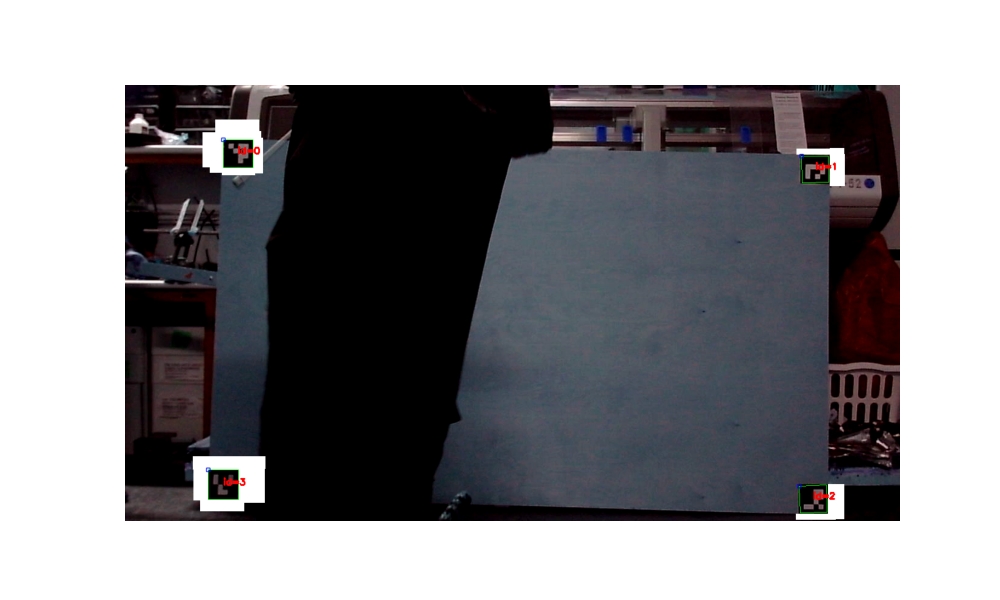

In [95]:
# Aruco marker detection and frame mapping
from cv2 import aruco

aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_100)
parms =  aruco.DetectorParameters()
# Defaults for these are: min 3, max 23, step 10
# This will need tweaking in the future, need to take images at min and max distances to board
parms.adaptiveThreshWinSizeMin = 5
parms.adaptiveThreshWinSizeMax = 15
parms.adaptiveThreshWinSizeStep = 5

aruco_detector = aruco.ArucoDetector(aruco_dict, parms)

# Read first frame of video:
cap = cv.VideoCapture( os.path.join(fdir, fname))
if not cap.isOpened():
    raise ValueError(f'Could not open video file: {os.path.join(fdir,fname)}')

ret, frame = cap.read()

cap.release() # only need first frame, can let the rest of the stream go

# cv.imwrite(os.path.join(fdir, "first_frame.png"), frame)
frame = cv.imread(os.path.join(fdir, "first_frame_edited.png"))

# frame_g = cv.cvtColor( frame, cv.COLOR_BGR2GRAY )
markerCorners, markerIds, rejectedCandidates = aruco_detector.detectMarkers(frame)

print(markerCorners)
print(markerIds)
# print(rejectedCandidates)

# plt.figure();
# plt.imshow(frame)

# # Annotate failed detections:
# for rej in rejectedCandidates:
#     frame = cv.drawMarker(frame, (int(rej[0][0][0]), int(rej[0][0][1])), (0,0,255), markerType=cv.MARKER_TILTED_CROSS, 
#                                      markerSize=15, thickness=2, line_type=cv.LINE_AA)

aruco.drawDetectedMarkers(frame, markerCorners, markerIds)

plt.figure(figsize=(10,6));
plt.imshow(frame)
plt.axis('off')


 
# src: coordinates in the source image
# dst: coordinates in the output image

In [180]:
# Assume we got all four Aruco markers, and get the outer corners of all
# (Assumes ID = 0 is the upper left, and we go clockwise from there)

id_idxs = np.argsort(markerIds.flatten())
# Aruco corner coordinates are x, y, col, row NOT row, col , also start at top left and go clockwise
# Just write out what they are as opposed to getting too "clever" to be readable here:
markerCorners = [mc.astype(int) for mc in markerCorners]

board_UL = markerCorners[id_idxs[0]][0][0]
board_UR = markerCorners[id_idxs[1]][0][1]
board_LR = markerCorners[id_idxs[2]][0][2]
board_LL = markerCorners[id_idxs[3]][0][3]

board_corners_img = np.array([board_UL, board_UR, board_LR, board_LL])
# Debug display:
# frame_debug = frame.copy()
# for point in board_corners_img:
#     cv.drawMarker(frame_debug, point, (255,0,0), markerType=cv.MARKER_CROSS, 
#                                      markerSize=15, thickness=2, line_type=cv.LINE_AA)
# plt.figure();
# plt.imshow(frame_debug)
# plt.axis('off')

# Technically these are measured from the Aruco marker outer corners, where the black Aruco box meets the outer border
# Use approximate board dimensions for now:
board_width_mm = round(25.4*72)
board_height_mm = round(25.4*48)

# Assume lower left = (0,0) indexed coordinates for now, can change as needed
board_corners_mm = np.array([(0, board_height_mm), (board_width_mm, board_height_mm), (board_width_mm, 0), (0,0)])

# Perspective warp according to the 4 Aruco markers (OpenCV obnoxiously expects this to be in 32 bit floats)
transform_img_to_board = cv.getPerspectiveTransform(board_corners_img.astype(np.float32), board_corners_mm.astype(np.float32))

def im_x_y_to_board_x_y(im_coords, transform):
    ''' Transform image coordinates (in col, row / x, y) to board coordinates '''
    # Mathematical definition: [t'x', t'y', t']' = transform * [x, y, 1]
    # Thus we tack on 1 to our original 2d coordinates to get a 3-vector, multiply the matrices, and divide the resulting x and y by the third (scaling) element
    result = np.matmul( transform, np.array([im_coords[0], im_coords[1], 1]).transpose())
    # Return properly scaled 2d coordinate
    return (result[0]/result[2], result[1]/result[2])

# print('Upper left coords:')
print('Upper right coords:')
# print( im_x_y_to_board_x_y([162, 90], transform_img_to_board) ) # coordinates manually taken from upper left Aruco marker corner of 1st frame
print( im_x_y_to_board_x_y([1161, 117], transform_img_to_board) ) # coordinates manually taken from upper left Aruco marker corner of 1st frame
print(f'Board width: {board_width_mm}, Board height: {board_height_mm}')

Upper right coords:
(1829.0000000000002, 1219.0)
Board width: 1829, Board height: 1219


In [18]:
WRITE_OUTPUT = False
READ_FILE = True
read_livecam_id = 0
SHOW_ORIENTATION = True
SHOW_CONTOUR = False
SHOW_BBOX = True
SHOW_CENTROIDS = True

# Magic numbers:
# minimum object contour area to be tracked:
# TODO: Do Aruco transform to real coordinates (i.e., cm), and put in terms of cm^2 instead of pixels here

# min_contour_area = 500  
min_contour_area = 2000
max_contour_area = 10000


backsub_thresh = 180 # Threshold for movement in background subtracted image

# Process only subset of video:
frame_start = 300
frames_to_proc = 450

# Amounts to scale direction vector..
# maxvar_scaling = 50 # old method
maxvar_scaling = 0.02 # Since we don't divide x,y by their stdev, things get large

# Attempt manual mtion tracking method - background subtraction and contours:
back_sub = cv.createBackgroundSubtractorMOG2()

frame_end = frame_start + frames_to_proc
frame_num = 0

if READ_FILE:
    cap = cv.VideoCapture( os.path.join(fdir, fname))
    # Advance the capture to skip the first frames we don't want:
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_start)
else:
    frames_to_proc = np.inf
    cap = cv.VideoCapture(read_livecam_id)

# Configure output stream:
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# out_fn = fname.replace('.mov', '_Annotated.mp4v')
out_fn = fname.replace('.mov', '_test2Annotated.avi')

if WRITE_OUTPUT:
    out = cv.VideoWriter(os.path.join(fdir, out_fn),
                          cv.VideoWriter_fourcc('M','P','4','V'), 24, (frame_width,frame_height))
    
    if not out.isOpened():
        raise ValueError('VideoWriter failed to initialize')

while cap.isOpened():
    frame_num += 1
    
    if frame_num > frame_end:
        break
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    # Apply background subtraction
    fg_mask = back_sub.apply(frame)

    # apply global threshold to remove shadows
    retval, mask_thresh = cv.threshold( fg_mask, backsub_thresh, 255, cv.THRESH_BINARY)

    # Binary erosion to remove small motion pixel groups
    # set the kernal
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    # Apply erosion
    mask_eroded = cv.morphologyEx(mask_thresh, cv.MORPH_OPEN, kernel)

    # Find contours
    contours, hierarchy = cv.findContours(mask_eroded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)    
 
    # Filter contours to allow only larger objects:
    contour_areas = [cv.contourArea(c) for c in contours]
    large_contours = [cnt for cnt, a in zip(contours,contour_areas) if a > min_contour_area and a < max_contour_area ]
    centroids = [get_centroid(c) for c in large_contours]

    # initialize annoated frame:
    frame_ct = frame.copy()
    
    # Annotated frame:
    if SHOW_CONTOUR:
        frame_ct = cv.drawContours(frame, large_contours, -1, (0, 255, 0), 2)
    elif SHOW_BBOX:
        for c in large_contours:
            rect = cv.boundingRect(c)
            x,y,w,h = rect
            cv.rectangle(frame_ct, (x,y), (x+w,y+h), (0, 255, 0), 2)
        
    # Draw centroids with extra markers if we're not using orientation markers:
    if not SHOW_ORIENTATION and SHOW_CENTROIDS:
        for c in centroids:
            frame_ct = cv.drawMarker(frame_ct, c, (0, 0, 255), markerType=cv.MARKER_TILTED_CROSS, 
                                     markerSize=15, thickness=2, line_type=cv.LINE_AA)
    elif SHOW_ORIENTATION:
        # Draw eigenvectors of the covariance matrix scaled by eigenvalues
        # Gets across "direction" axis of variance, and if they're equally sized it's symmetric
        for c, cent in zip(large_contours, centroids):
            eigenvecs = get_max_variance_vectors(c, cent)
            for ev in eigenvecs:
                vary = round(maxvar_scaling*ev[0])
                varx = round(maxvar_scaling*ev[1])
                # Sign of max variance vector is arbitrary, so draw a line in both + and - directions from centroid
                frame_ct = cv.line( frame_ct, (cent[0]-vary, cent[1]-varx), (cent[0]+vary, cent[1]+varx), (0, 0, 255), 2 )
    
    # Display the resulting frame
    cv.imshow('Frame_final', frame_ct)

    if WRITE_OUTPUT:
        # Write it to the video output file:
        out.write(frame_ct)
    
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
if WRITE_OUTPUT:
    out.release()
    
cv.destroyAllWindows()

In [6]:
# scratch
# c = contours[6]
# cr = np.reshape(c, (c.shape[0], 2))
# cr.shape

# disp_scaling = 10

# centroid = get_centroid(c)
# dcr = cr - centroid
# norms = np.linalg.norm(dcr, axis=1).reshape((cr.shape[0],1))
# dcrnorm = dcr / norms
# diry = dcrnorm[:,0].mean()
# dirx = dcrnorm[:,1].mean()
# disp_dirvec = ( round( disp_scaling*diry ), round( disp_scaling*dirx ) )

In [6]:
# Play back video with no annotations:

while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    cv.imshow('frame', gray)
    if cv.waitKey(1) == ord('q'):
        break
            
cap.release()
cv.destroyAllWindows()

# Test Nanotrack V2 neural network tracker

Built into openCV now, but is a _tracker_ rather than _detector_, thus it requires the object of interest to be labeled in the first frame


Here we experiment with running the above algo to find the cat initially and then switching over to the lighter weight tracker

In [69]:
# Process only subset of video:
frame_start_tracker = 380
frame_end = 600 # 450


frame_end = frame_start + frames_to_proc
frame_num = 0

params = cv.TrackerNano_Params()
# an onnx file downloaded from the url displayed in (your doc)[https://docs.opencv.org/4.7.0/d8/d69/classcv_1_1TrackerNano.html]
params.neckhead = '/home/chris/cattown/nanotrack_head_sim.onnx'
params.backbone = '/home/chris/cattown/nanotrack_backbone_sim.onnx' 
tracker = cv.TrackerNano_create(params)

# Manually extracted tracking object ROI from 1st frame in cells below
track_box = (1016, 464, 146, 174)

if READ_FILE:
    cap = cv.VideoCapture( os.path.join(fdir, fname))
    # Advance the capture to skip the first frames we don't want:
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_start_tracker)
else:
    frames_to_proc = np.inf
    cap = cv.VideoCapture(read_livecam_id)

while cap.isOpened():
    frame_num += 1
    
    if frame_num > frame_end:
        break
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break


    # Hack: get ROI manually from first frame:
    if frame_num == 1:
        # Uncomment to select ROI in cell below
        # first_frame = frame.copy()
        # Initialize tracker on first frame
        tracker.init(frame, track_box)

    else:
        success, box = tracker.update(frame)

        if success:
            x,y,w,h = box
            frame_ct = frame.copy()
            cv.rectangle(frame_ct, (x,y), (x+w,y+h), (0, 255, 0), 2)
            cv.imshow('frame_tracker', frame_ct)
        else:
            cv.imshow('frame_tracker', frame) # no box
        
        if cv.waitKey(30) == ord('q'):
            break

# frame = cv.imread('img.png', cv.IMREAD_GRAYSCALE) # the image is a grayscale image
# cvt_frame = cv.cvtColor(frame, cv.COLOR_GRAY2RGB)
# box = cv.selectROI("frame", cvt_frame)
# tracker.init(cvt_frame, box)

# for frame in frames:
#     flag, box = self.tracker.update(cv.cvtColor(frame, cv.COLOR_GRAY2RGB))

cap.release()
# if WRITE_OUTPUT:
#     out.release()
    
cv.destroyAllWindows()


QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to tar

Can't receive frame (stream end?). Exiting ...


In [64]:
flag

True

In [55]:
# Use theses cells below to draw a box around the object,
# then copy/paste the box info up to cell above to initialize the tracker
# (this has already been done above, so only need to run these if we want to redo it)
cv.destroyAllWindows()

In [56]:
init_box = cv.selectROI("Select ROI", first_frame)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to target thread (0x5610bf84d160)

QObject::moveToThread: Current thread (0x5610bf84d160) is not the object's thread (0x5610bfbdd760).
Cannot move to tar

In [60]:
box

(1016, 464, 146, 174)

# Thoughts

Nanotracker works in the sense that, once given the initial box around the object, it does track it.

The bounding box jitters around a bit when the object is near the like-colored border.  This is probably okay.

It doesn't do a good job of realizing when it's gone out of frame, especially when it's the same color as the border
This example only shows tracking of one object.  OpenCV does have a MultiTracker class meant to run multiple trackers at once, and each one would have to be initialized / de initialized as it came on the screen

If there were major speed advantages to using this over a frame-by-frame background subtracting motion detector and state memory, we might consider an optimization where we do motion detection to look for new objects, then hand them over to the tracker.  Maybe this could run on some limited ROI border around the cat board.  However, this wouldn't pick up cats leaping in from the direction of the camera and bypassing the outer border.  The inability of this tracker to report failure is also troubling... we would have to run some other check if the tracked object was near the border and not moving for a while to make sure it was still there.

Caveat: It's possible that if we let the video go on longer the nanotracker will realize the object is gone.  It only had a second or two in this case.

TODO: Try on occluding human example?